In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
from scipy.stats import chi2_contingency
import pingouin as pg

In [2]:
# File path to raw data (sampled version)
raw_data = "../SampledSAPCRData.xlsx"
# File path to algorithm output (alg labels) data
ind_time_filepath = "../output_data_au/Simulation_Results_2023-08-15T100831.821222/individual_time_point_data.csv"
# File path to hand label data
hand_labels_filepath = "../Ned Labelling.xlsx"

In [3]:
# Read all data files into dataframes
raw_data_df = pd.read_excel(raw_data, sheet_name="PROM-RulesBasedAlgorithmData_R2")
print(len(raw_data_df))
print(raw_data_df.head())

ind_time_df = pd.read_csv(ind_time_filepath)
print(len(ind_time_df))
print(ind_time_df.head())

hand_labels_df = pd.read_excel(hand_labels_filepath, sheet_name="Sheet1")
print(len(hand_labels_df))
print(hand_labels_df.head())

564
   Unnamed: 0  CapstudiesID AproxPromDate  Interval  PROAnswerSetID  \
0          55         19622    2021-04-15         0         1399672   
1          67         12775    2017-12-02         6          321981   
2          69         12779    2017-11-01         6          320709   
3         109         12628    2017-08-24         6          303211   
4         115         12661    2017-09-04         6          305539   

              QueEpic1  QueEpicAnsCode1               QueEpicQ2  \
0    5-Rarely or never              5.0         4-Total control   
1    5-Rarely or never              5.0         4-Total control   
2    5-Rarely or never              5.0         4-Total control   
3    5-Rarely or never              5.0         4-Total control   
4  4-About once a week              4.0  3-Occasional dribbling   

   QueEpicAnsCode2 QueEpicQ3  ...   QueEpicQ13B QueEpicAnsCode13B  \
0              4.0    0-None  ...  0-No problem               1.0   
1              4.0    0-None

# Preprocessing

The preprocessing mostly involves a lot of linking:

• Linking the participant ids with their report ids (and the intervals at which these reports occur)

• Linking the hand label data to the algorithm label data

Also remove algorithm labels that do not have a hand label equivalent

In [4]:
# Get list of participant ids that were hand labelled
hand_label_ids = list(hand_labels_df[(hand_labels_df['Unnamed: 0'].notna())]['Unnamed: 0'])
print(f"{len(hand_label_ids)} participants with hand labels")

104 participants with hand labels


In [5]:
# Drop algorithm labels that don't have a hand label equivalent
drop_i = []
for index, row in ind_time_df.iterrows():
    if int(row['Patient Identifier'].split('_')[0]) not in hand_label_ids:
        drop_i.append(index)
        
ind_time_df = ind_time_df.drop(drop_i)
print(f"{len(ind_time_df)} algorithm labels")

483 algorithm labels


In [6]:
# Link indices together
idx = {} # {participant_id: [(report_id, interval)]}
participant_ids = list(raw_data_df['CapstudiesID'])
report_ids = list(raw_data_df['PROAnswerSetID'])
intervals = list(raw_data_df['Interval'])
for i in range(len(participant_ids)):
    if int(participant_ids[i]) not in hand_label_ids:
        continue
    if participant_ids[i] not in idx:
        idx[participant_ids[i]] = [(report_ids[i], intervals[i])]
    else:
        idx[participant_ids[i]] += [(report_ids[i], intervals[i])]

for id in idx:
    for interval in [0, 3, 6, 12, 24, 60]:
        if interval not in [report[1] for report in idx[id]]:
            idx[id].append((None, interval))
    idx[id].sort(key=lambda report: report[1])

print(f"{len(idx)} participants with algorithm labels")

104 participants with algorithm labels


In [7]:
# Create a list of ids in the format that the algorithm outputs uses
# "pid_rid.json" where pid is the participant id and rid is the report id
sampled_ids = [] # ["pid_rid.json"]
for id in idx:
    for report in idx[id]:
        if report[0] != None:
            sampled_ids.append(f"{id}_{report[0]}.json")
sampled_ind_time_df = alert_domains = ind_time_df[ind_time_df['Patient Identifier'].isin(sampled_ids)]

In [8]:
# Aggregate algorithm and hand labels together
labels = {} # {participant_id: {hand: hand_label_data, alg: alg_output_df}}
for id in idx:
    hand_label = hand_labels_df.loc[(hand_labels_df['Unnamed: 0'] == id)] # 'Unamed: 0' is the name of the column with the ids
    if len(hand_label) == 0:
        continue     
    labels[id] = {}
    labels[id]["hand"] = []
    hand_label = list(hand_label.iloc[0])
    col_i = 1
    for i in range(6):
        report_data = []
        for j in range(28):
            report_data.append(list(hand_label)[col_i])
            col_i += 1
        report = {}
        report["UI"] = {"q2": report_data[0], "q3": report_data[1], "q4a": report_data[2], "label": report_data[3], "colour": report_data[4]}
        report["UO"] = {"q4b": report_data[5], "q4c": report_data[6], "q4d": report_data[7], "label": report_data[8], "colour": report_data[9]}
        report["BF"] = {"q6a/6e(max)": report_data[10], "q6b": report_data[11], "q6d": report_data[12], "q7": report_data[13], "label": report_data[14], "colour": report_data[15]}
        report["SF"] = {"q8b": report_data[16], "q9": report_data[17], "q12": report_data[18], "label": report_data[19], "colour": report_data[20]}
        report["HF"] = {"q13a/13b(max)": report_data[21], "q13c": report_data[22], "q13d": report_data[23], "label": report_data[24], "colour": report_data[25]}
        report["Global"] = {"label": report_data[26], "colour": report_data[27]}
        labels[id]["hand"].append(report)
    
    labels[id]["alg"] = []
    for report in idx[id]:
        if report[0] == None:
            labels[id]["alg"].append(None)
            continue
        labels[id]["alg"].append(ind_time_df.loc[(ind_time_df['Patient Identifier'] == f"{id}_{report[0]}.json")].iloc[0])


In [12]:
# Map the hand labels (stable, mild, moderate, urgent) to algorithm labels (normal, abnormal, clinically urgent alert)
def hand_label_conversion(hand_label):
    if hand_label == "Stable":
        return "Normal"
    elif hand_label == "Mild":
        return "Abnormal"
    elif hand_label == "Moderate" or hand_label == "Urgent":
        return "Clinically Urgent Alert"
    else:
        return ""

def is_same_label(alg_label, hand_label):
    return alg_label == hand_label_conversion(hand_label)

# Label Distribution Breakdown

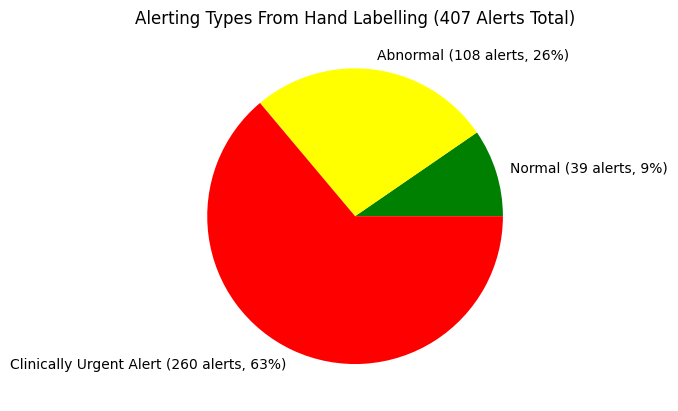

In [14]:
# Look at the frequency of alert types from hand labelling

alert_types = ["Normal", "Abnormal", "Clinically Urgent Alert"]
# Get the frequency for each type of alert in the hand labeled alerts
alert_counts = [(alert, hand_labels.count(alert)) for alert in alert_types]
# Create the pie chart
plt.pie([alert[1] for alert in alert_counts], labels = [f"{alert[0]} ({alert[1]} alerts, {int(100*alert[1]/total_labels)}%)" for alert in alert_counts], colors=["green","yellow","red"]
)
plt.title(f"Alerting Types From Hand Labelling ({total_labels} Alerts Total)")
plt.show()

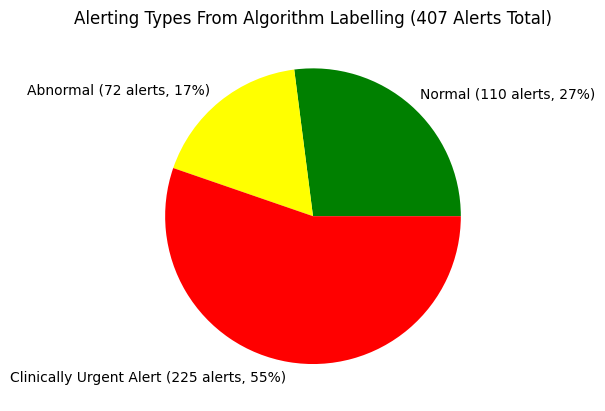

In [15]:
# Look at the frequency of alert types from hand labelling

alert_types = ["Normal", "Abnormal", "Clinically Urgent Alert"]
# Get the frequency for each type of alert in the algorithm labeled alerts
alert_counts = [(alert, alg_labels.count(alert)) for alert in alert_types]
# Create the pie chart
plt.pie([alert[1] for alert in alert_counts], labels = [f"{alert[0]} ({alert[1]} alerts, {int(100*alert[1]/total_labels)}%)" for alert in alert_counts], colors=["green","yellow","red"])
plt.title(f"Alerting Types From Algorithm Labelling ({total_labels} Alerts Total)")
plt.show()

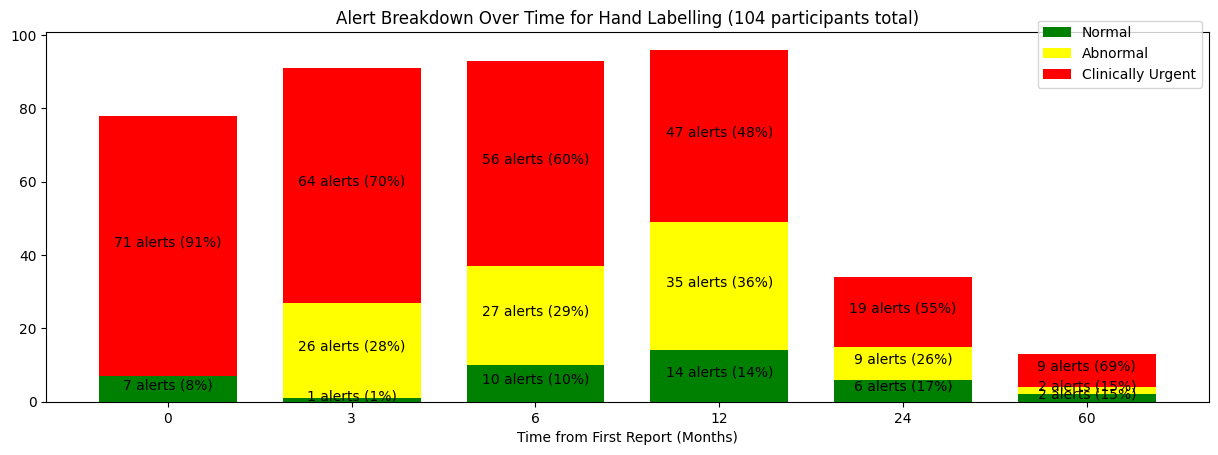

In [17]:
# Create stacked bar chart for hand label alerts over months

date_points = ["0", "3", "6", "12", "24", "60"] # measured in months

# Alerts by report number
# Get list of alerts
alert_types = [hand_label_conversion(report['Global']['label']) for participant in labels for report in labels[participant]['hand']] # list(labels['Final Alert State'])
# Get the report # for each alert
alert_times = [report_i for participant in labels for report_i in range(len(labels[participant]['hand']))]
# Get the participant id for each alert
patient_ids = [participant for participant in labels for report in labels[participant]['hand']]
alerts_by_patient = {} # {id : [(datetime, alert_type)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i]
    time = alert_times[i]
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i]))
        
alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
alert_counts = dict(alert_counts)

for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        if (i == 0 and sorted_alerts[i][1] == "Abnormal") or sorted_alerts[i][1] == "":
            continue 
        alert_counts[date_points[i]][sorted_alerts[i][1]] += 1

# Everything below this is setting up the stacked bar charts
# Load data
old_counts = alert_counts
hand_alert_counts = {
    "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
    "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
    "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
}
# Set colours for alerts
alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(15)
bottom = np.zeros(len(date_points))

# Created stacked bars
for alert_type, alert_count in hand_alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

total_alert_counts = [hand_alert_counts["Normal"][date_i] + hand_alert_counts["Abnormal"][date_i] + hand_alert_counts["Clinically Urgent"][date_i] for date_i in range(len(date_points))]
total_participant_count = len(list(set(patient_ids)))

# Labels for  bar stack segments
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_alert_counts[i%len(date_points)])}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alert Breakdown Over Time for Hand Labelling ({total_participant_count} participants total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()


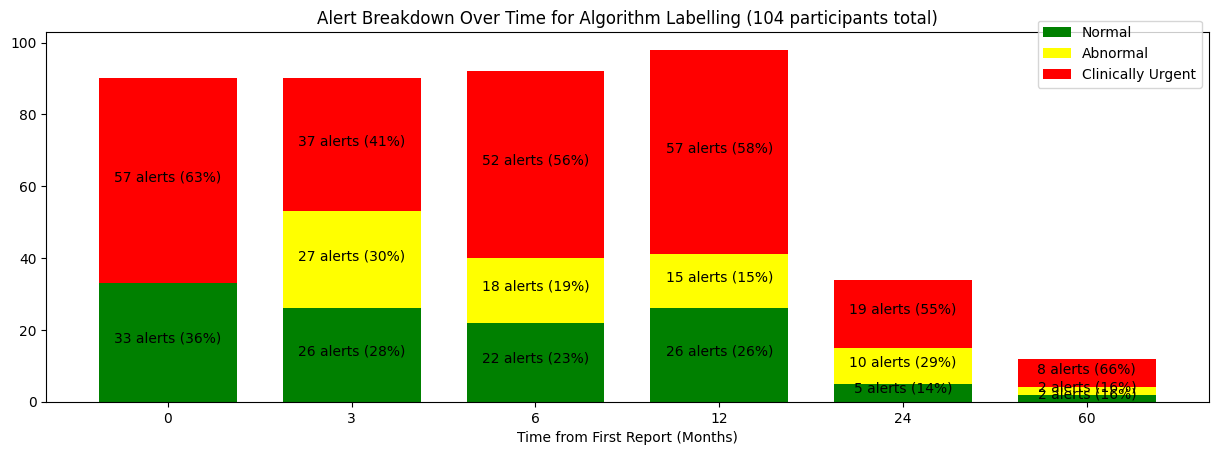

In [172]:
# Create stacked bar chart for algorithm label alerts over months
date_points = ["0", "3", "6", "12", "24", "60"] # measured in months

# Get alerts by report number
alerts_by_patient = {} # {id : [(datetime, alert_type)]}
alert_types = list(sampled_ind_time_df['Final Alert State'])
patient_ids = list(sampled_ind_time_df['Patient Identifier'])
alert_times = []
for id in patient_ids:
    pid = id.split('_')[0]
    rid = id.split('_')[1][:-5]
    interval = list(raw_data_df[(raw_data_df['CapstudiesID']== int(pid)) & (raw_data_df['PROAnswerSetID']== int(rid))]["Interval"])[0]
    alert_times.append(interval)

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    time = alert_times[i]
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i]))
        
alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
alert_counts = dict(alert_counts)

for patient_id in alerts_by_patient.keys():
    for date in date_points:
        if int(date) not in [alert[0] for alert in alerts_by_patient[patient_id]]:
            alerts_by_patient[patient_id].append((int(date), ""))
        
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        if (i == 0 and sorted_alerts[i][1] == "Abnormal") or sorted_alerts[i][1] == "":
            continue
        alert_counts[date_points[i]][sorted_alerts[i][1]] += 1

# Everything below this is setting up the stacked bar charts
# Load data
old_counts = alert_counts
alg_alert_counts = {
    "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
    "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
    "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
}

# Set colours for alerts
alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.75

fig, ax = plt.subplots()
fig.set_figwidth(15)
bottom = np.zeros(len(date_points))

# Create stacked bars
for alert_type, alert_count in alg_alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

total_alert_counts = [alg_alert_counts["Normal"][date_i] + alg_alert_counts["Abnormal"][date_i] + alg_alert_counts["Clinically Urgent"][date_i] for date_i in range(len(date_points))]

# Set labels for stacked bar segments
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_alert_counts[i%len(date_points)])}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alert Breakdown Over Time for Algorithm Labelling ({total_participant_count} participants total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()


# Agreement Analysis

This section involves comparing the agreement between the hand labels and algorithm labels. In general we see that the hand labelling tends to be more conservative (less normal, more abnormal/urgent)

In [293]:
subgroups = ["All", "Radiotherapy", "Surgery/Observation", "Normal Baseline Alert", "Clinically Urgent Baseline Alert"]
population = "Clinically Urgent Baseline Alert" # pick one of the above

In [294]:
# Set ids that we want to compare in analysis
keep_ids = []

participant_df = pd.read_excel(raw_data, sheet_name="Person")

if population == "All":
    keep_ids = list(labels.keys())
elif population == "Radiotherapy":
    keep_ids = list(participant_df[(participant_df["iTreatment"] == "XRT") & (participant_df["CapstudiesID"].isin(labels.keys()))]["CapstudiesID"])
elif population == "Surgery/Observation":
    keep_ids = list(participant_df[((participant_df["iTreatment"] == "RP") | (participant_df["iTreatment"] == "OBSERVATION")) & (participant_df["CapstudiesID"].isin(labels.keys()))]["CapstudiesID"])
else:
    report_id_data = raw_data_df[raw_data_df["CapstudiesID"].isin(labels.keys())].groupby('CapstudiesID')['PROAnswerSetID'].apply(list).to_dict()
    interval_data = raw_data_df[raw_data_df["CapstudiesID"].isin(labels.keys())].groupby('CapstudiesID')['Interval'].apply(list).to_dict()
    alert_data = ind_time_df.groupby('Patient Identifier')['Final Alert State'].apply(list).to_dict()
    
    normal_ids = [] # [(patient_id, report_id)]
    urgent_ids = [] # [(patient_id, report_id)]
    for id in report_id_data.keys():
        to_keep = list(zip(report_id_data[id], interval_data[id], [alert_data[f"{id}_{report_id}.json"][0] for report_id in report_id_data[id]]))
        to_keep = sorted(to_keep, key=lambda x: x[1]) # sort by interval
        if to_keep[0][2] == 'Normal':
            normal_ids.append(id)
        elif to_keep[0][2] == 'Clinically Urgent Alert':
            urgent_ids.append(id)
    if population == "Normal Baseline Alert":
        keep_ids = list(set(normal_ids))
    elif population == "Clinically Urgent Baseline Alert":
        keep_ids = list(set(urgent_ids)) 
    else:
        raise Exception("Please choose a proper population")

## Confusion Matrix + Cohen-Kappa Score + Interclass Correlation Coefficient

In [295]:
def label_to_numeric(label):
    if label == "Normal":
        return 0
    elif label == "Abnormal":
        return 1
    else:
        return 2

In [296]:
total_labels = 0
accurate_labels = 0
hand_labels = []
alg_labels = []
label_ids = []

for id in keep_ids:
    for i in range(6):
        hand_label = labels[id]["hand"][i]["Global"]["label"]
        if isinstance(labels[id]["alg"][i], type(None)) or (hand_label not in ["Stable", "Mild", "Moderate", "Urgent"]):
            continue
        total_labels += 1
        alg_label = labels[id]["alg"][i]["Final Alert State"]
        if is_same_label(alg_label, hand_label):
            accurate_labels += 1
        hand_labels.append(hand_label_conversion(hand_label))
        alg_labels.append(alg_label)
        label_ids.append(f"{id},{i}")

In [297]:
print(f"{int(100*accurate_labels/total_labels)}% agreement ({accurate_labels}/{total_labels})")
ck_score = cohen_kappa_score(hand_labels, alg_labels)
print(f"cohen kappa score: {ck_score}")

68% agreement (170/248)
cohen kappa score: 0.28326355181740703


In [298]:
icc_df = pd.DataFrame({"label_id": label_ids + label_ids,
                    "label_source": ['hand' for label in hand_labels] + ['algorithm' for label in alg_labels],
                    "value": [label_to_numeric(label) for label in hand_labels] + [label_to_numeric(label) for label in alg_labels]})
icc = pg.intraclass_corr(data=icc_df, targets='label_id', raters='label_source', ratings='value')
# look at ICC3 because all raters are used for all alerts
icc = icc.set_index('Description')
icc = icc.loc['Single fixed raters', 'ICC']
print(f"interclass correlation coefficient: {icc}")

interclass correlation coefficient: 0.4153869147703922


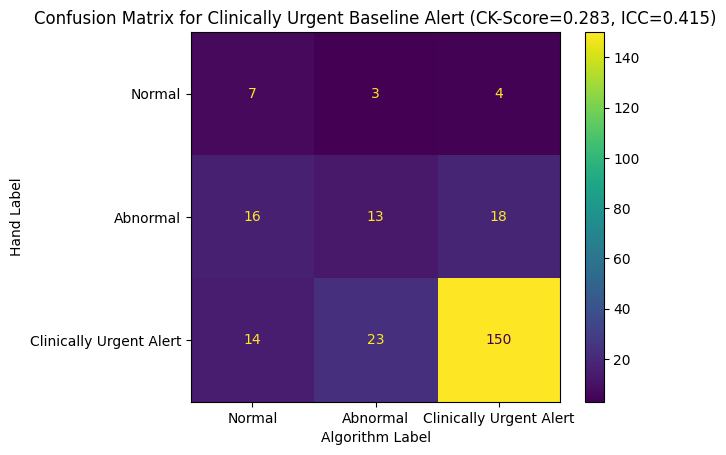

In [299]:
cm = confusion_matrix(hand_labels, alg_labels, labels=["Normal", "Abnormal", "Clinically Urgent Alert"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal", "Clinically Urgent Alert"])
disp.plot()
plt.title(f"Confusion Matrix for {population} (CK-Score={round(ck_score, 3)}, ICC={round(icc, 3)})")
plt.xlabel("Algorithm Label")
plt.ylabel("Hand Label")
plt.show()

## Chi-Square Test

In [243]:
date_points = ["0", "3", "6", "12", "24", "60"] # measured in months

exp_alert_counts = hand_alert_counts
alert_counts = alg_alert_counts
    
for report_no in range(0, 6):
    f_exp = []
    f_obs = []
    if report_no == 0:
        f_exp = np.array([exp_alert_counts["Normal"][report_no],
                      exp_alert_counts["Clinically Urgent"][report_no]])
        f_obs = np.array([alert_counts["Normal"][report_no],
                      alert_counts["Clinically Urgent"][report_no]]) 
    else: 
        f_exp = np.array([exp_alert_counts["Normal"][report_no],
                          exp_alert_counts["Abnormal"][report_no],
                          exp_alert_counts["Clinically Urgent"][report_no]])
        f_obs = np.array([alert_counts["Normal"][report_no],
                          alert_counts["Abnormal"][report_no],
                          alert_counts["Clinically Urgent"][report_no]]) 
    stat, p, dof, expected = chi2_contingency([f_exp, f_obs])
    print(f"{date_points[report_no]} months: stat={stat},p={p}")
print()

0 months: stat=16.17067307692308,p=5.78833561347369e-05
3 months: stat=30.38024032243265,p=2.5293832283080267e-07
6 months: stat=6.442930994926669,p=0.03989654710856997
12 months: stat=12.542252910779695,p=0.0018900982721989814
24 months: stat=0.14354066985645933,p=0.9307446307989679
60 months: stat=0.018853695324283593,p=0.9906174457745186

